![](https://drive.google.com/uc?export=view&id=17MxDF2iq5MBzkvExOihZY9ZNks-V4tRl)

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive/', force_remount=True)
%cd "/content/gdrive/MyDrive/M2 SETSIS/Deep Learning Son/repertoire_tp/1.DataPreprocessing"
!echo $PWD

Mounted at /content/gdrive/
/content/gdrive/MyDrive/M2 SETSIS/Deep Learning Son/repertoire_tp/1.DataPreprocessing
/content/gdrive/MyDrive/M2 SETSIS/Deep Learning Son/repertoire_tp/1.DataPreprocessing


<h1 align="left" style="color:#000051;font-size: 30px">TP : Classifiez des émotions vocales avec du deep learning</h1>

Pour ce TP, vous implémenterez un classifieur à base de réseau de neurones sur des données combinant les jeux de données RAVDESS et TESS avec la librairie keras. 
Repartez de ce notebook Jupyter qui passe en revue chaque partie du TP pour présenter des preuves et une analyse de vos résultats

<h1 align="left" style="color:#000051;font-size: 25px">Partie 1 : Pré-traitement des données</h1>

Dans cette partie nous nous attacherons principalement à pré-traiter les données audio du jeu de données, c'est-à-dire préparer les données en vue de les utiliser comme entrées du modèle de deep learning que nous construirons par la suite

<h2 style="text-align: left; color:#20a08d; font-size: 25px"><span>💾 <strong>A propos des jeux de données </strong></span></h2>

Pour ce TP, nous utiliserons 2 jeux de données

- **RAVDESS : Ryerson Audio-Visual Database of Emotional Speech and Song**
https://zenodo.org/record/1188976#.X4sE0tDXKUl
  - RAVDESS a été enregistrée avec 24 acteurs professionnels (12 femmes, 12 hommes), prononçant deux phrases lexicalement identiques avec un accent nord-américain neutre. Chaque phrase est prononcée avec deux niveaux d'intensité émotionnelle (normal, fort).
  - **1440 fichiers** = 24 acteurs x 60 fichiers audio par acteur
  - **8 émotions** (neutre, calme, joie, tristesse, colère, peur, dégout, surprise).



- **TESS : Toronto Emotional Speech Set**
https://tspace.library.utoronto.ca/handle/1807/24487
  - Ces données ont été enregistrées par le Northwestern University Auditory. Un ensemble de 200 mots cibles ont été prononcés dans la phrase "Dites le mot _____" par deux actrices (âgées de 26 et 64 ans) et des enregistrements ont été réalisés lorsque ces phrases ont été prononcées avec chacune des sept émotions décrites ci-dessous.
Les deux actrices ont été recrutées dans la région de Toronto. Les deux actrices parlent l'anglais comme première langue, ont fait des études universitaires et ont une formation musicale.
  - **2800 fichiers** = 2 acteurs x 200 phrases x 7 émotions
  - **7 émotions** (neutre, joie, tristesse, colère, peur, dégoût, surprise)('calme' ne fait pas partie de cette BD) 

Pour ce TP, pour des considérations de volume de données, nous n'avons retenu que 4 des émotions:
- **neutre**
- **joie**
- **tristesse**
- **colère**

<h2 style="text-align: left; color:#20a08d; font-size: 25px"><span>📥 <strong>1. Import des librairies </strong></span></h2>

Si vous avez besoin d'installer des libraires Python pour ce TP, décommentez et exécutez la cellule ci-dessous

In [ ]:
#!pip3 install numpy
!pip3 install pydub
#!pip3 install librosa
!pip3 install noisereduce
#!pip3 install matplotlib
#!pip3 install IPython
#pip3 install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import random

from pydub import AudioSegment, effects
import librosa
import soundfile as sf
from scipy.io import wavfile
import noisereduce as nr

import matplotlib.pyplot as plt
from librosa import display   
import IPython.display as ipd 

<h2 style="text-align: left; color:#20a08d; font-size: 25px"><span>🔎 <strong>2. Exploration du jeu de données </strong></span></h2>

Avant de commencer à prétraiter les données, faisons-nous une idée de ce à quoi ressemble les données

In [ ]:
# Dataset folders
TESS_DATASET_FOLDER = "./dataset/tess"
RAVDESS_DATASET_FOLDER = "./dataset/ravdess"

# Example files
TESS_FILE_EXAMPLE = "./dataset/tess/YAF_goose_sad.wav"
RAVDESS_FILE_EXAMPLE = "./dataset/ravdess/03-01-01-01-01-01-02.wav"

Nous pouvons utiliser ici IPython pour écouter le contenu audio des fichiers

In [ ]:
# Ecoute de deux fichiers examples
rawsound_tess = AudioSegment.from_file(TESS_FILE_EXAMPLE)
rawsound_ravdess = AudioSegment.from_file(RAVDESS_FILE_EXAMPLE)

ipd.display(rawsound_tess)
ipd.display(rawsound_ravdess)

In [ ]:
def display_waveform(folder):
    
    '''
    Fonction pour afficher les formes d'ondes (waveform) de 5 fichiers audio aléatoirement choisis dans un répertoire

            Parameters:
                    folder (str): Chaine de caractère représentant le chemin d'accès au répertoire contenant les fichiers 

            Returns:
                    Rien : affiche les formes d'ondes
                    

    '''
    # Affichage des 5 fichiers audio aléatoirement choisis dans le jeu de données TESS

    # Récupération de la liste des fichiers
    tess_files_list = os.listdir(folder)
    tess_files_list = [os.path.join(folder, file) for file in tess_files_list]

    # Affichage
    plt.figure(figsize=(18, 3))
    for i in range(5):
        random_file = random.choice(tess_files_list)
        rawsound = AudioSegment.from_file(random_file)
        x, sr = librosa.load(random_file, sr = None)

        plt.subplot(1, 5, i+1)
        #plt.figure(figsize=(12,1))
        librosa.display.waveplot(x, sr)
        plt.title(os.path.basename(random_file))

    plt.show()

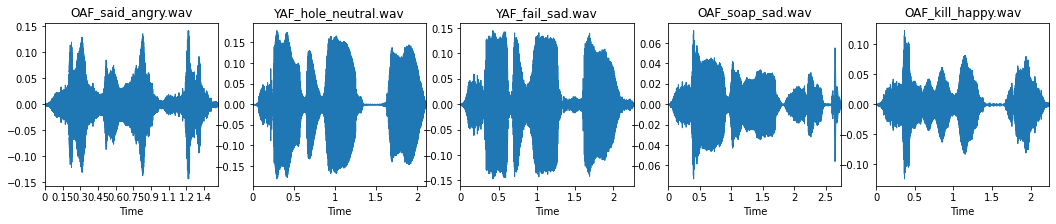

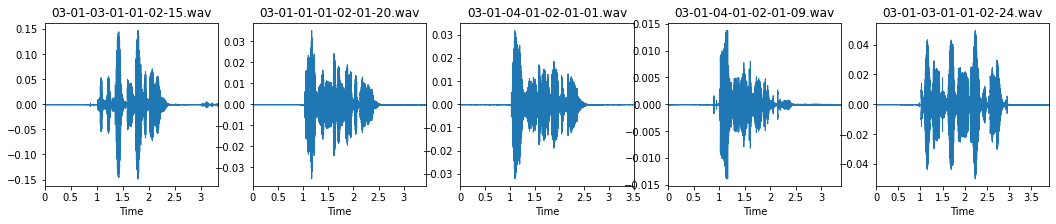

In [ ]:
display_waveform(folder=TESS_DATASET_FOLDER)
display_waveform(folder=RAVDESS_DATASET_FOLDER)

La forme d'onde représente la valeur de chaque échantillon audio en fonction du temps. Il s'agit juste d'une courbe représentant chaque échantillon en fonction du temps

![](https://drive.google.com/uc?export=view&id=1LoEcdpyJVfVMnQYhQDL7NcO8-P_GppKg)

<h2 style="text-align: left; color:#20a08d; font-size: 25px"><span>
🗃️ <strong>3. Pré-traitement du jeu de données</strong></span></h2>

Le schéma ci-dessous présente la chaine complète de pré-traitement à réaliser pour pré-traiter et extraire des caractéristiques de notre jeu de données.

Nous nous interessons ici dans un premier temps à la partie pré-traitement

![](https://drive.google.com/uc?export=view&id=1iw73hEvdOJn392qX30lhCdPMa5P0wfiY)

Le pré-traitement des audios nécessite 3 types de traitements:
1. **Extraction de la classe d'appartenance**

     * RAVDESS : Dans le jeu de données RAVDESS, le nom du fichier contient un nombre qui représente l'émotion exprimée dans le fichier audio. Un fichier RAVDESS consiste en un identifiant numérique en 7 parties (par exemple, 03-01-06-01-02-01-12.wav). Les deux premières parties étant fixes, le fichier peut être représenté comme suit : 03-01-X-X-X-X-X.wav. Les émotions sont indiquées dans la 3ème partie (Le 1er 'X') 
     * TESS : le nom de fichier contient une représentation directe d'une émotion. Les noms de fichier TESS sont composés de 3 parties, l'émotion étant indiquée dans la 3ème partie. Par exemple, dans le fichier "YAF_youth_happy.wav",  "happy".


2. **Fréquence d'échantillonnage** : nombre d'échantillons audio par seconde. La base de données RAVDESS a été enregistrée en 48 kHz et la base de données TESS a été enregistrée en 22,5 kHz.


3. **La séquence de pré-traitement** d'un fichier audio contient les traitements suivants :


* Objet 'AudioSegment' : L'audio est chargé dans un objet 'AudioSegment' par la bibliothèque pydub
* Normalisation : Chaque objet 'AudioSegment' est normalisé à + 5,0 dBFS.

* Conversion en tableau Numpy : La transformation de l'objet AudioSegment en un tableau d'échantillons est cruciale pour le reste du prétraitement.
* Suppression des silences : Les zones de silences, souvent au début et à la fin de l'extrait sonore, sont supprimées pour se débarrasser des données inutiles.
* Padding : Afin d'avoir des audios de la même taille, il est nécessaire de faire du padding sur chaque fichier audio afin qu'ils aient la même longueur. Ceci est crucial pour utiliser les données dans un modèle de deep learning
* Réduction de bruit : la réduction du bruit permet de supprimer d'éventuelles bruits, c'est-à-dire des données qui ne sont pas de la parole.

<h3 style="text-align: left; color:#20a08d; font-size: 20px"><span>🗃️ <strong>3.1 Pré-traitement unitaire </strong></span></h3>

Dans cette partie, nous développons pas à pas chacun des pré-traitements necessaires. Chaque pré-traitement sera codé dans une fonction et testé sur un fichier exemple.
Afin de s'assurer que les traitements sont bien réalisés, il faudra visualiser et écouter le fichier résultant du pré-traitement

In [ ]:
# Chemin d'accès au fichier exemple
RAVDESS_FILE_EXAMPLE = "./dataset/ravdess/03-01-01-01-01-01-02.wav"

<h4 style="text-align: left; color:#20a08d; font-size: 15px"><span>🗃️ <strong>3.1.0 Visualisation et écoute du fichier exemple</strong></span></h4>

La fonction ci-dessous permet d'afficher la forme d'onde et la barre d'écoute d'un fichier audio

In [ ]:
def visualize_waveform(audio_array, sampling_rate, display_audio=True):
    
    '''
    Fonction pour afficher la forme d'onde (waveform) d'un flux audio

            Parameters:
                    audio_array (Numpy array): Matrice de nombres de flottants représentant les échantillons audio du fichier audio
                    sampling_rate (int): Valeur entière représentant la fréquence d'échantillonnage du fichier audio
                    display_audio(bool) : booléen indiquant si la barre d'écoute du fichier audio devait être affichée ou non


            Returns:
                    Rien : affiche la forme d'ondes et/ou la barre d'écoute
                    

    '''

    plt.figure(figsize=(12,1))
    librosa.display.waveplot(audio_array, sampling_rate)
    plt.title("Audio waveform")
    
    if display_audio:
        max_value = audio_array.max()
        # Les fichiers wav avec des échantillons en format float32 doivent être entre +1 et -1
        # Si ce n'est pas le cas, il faut normaliser !
        if max_value > 1:
            audio_array = audio_array/max_value
        
        # Enregistrement d'un fichier temporaire    
        wavfile.write(filename="./tmp.wav", rate=sampling_rate, data=audio_array)
        
        # Affichage de l'audio pour playback        
        rawsound = AudioSegment.from_wav("./tmp.wav")
        ipd.display(rawsound)


Appliquons cette fonction pour visualiser la forme d'onde et ecouter le contenu du fichier exemple **RAVDESS_FILE_EXAMPLE**

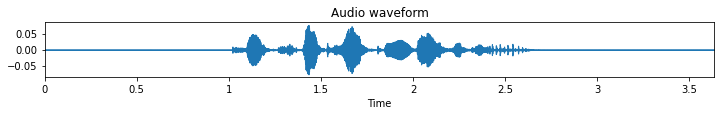

In [ ]:
audio_array, sampling_rate = librosa.load(RAVDESS_FILE_EXAMPLE, sr = None)
visualize_waveform(audio_array=audio_array, sampling_rate=sampling_rate, display_audio=True)

<h4 style="text-align: left; color:#20a08d; font-size: 15px"><span>🗃️ <strong>3.1.1 Instanciation de l'objet AudioSegment</strong></span></h4>

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code permettant d'instancier un objet AudioSegment à partir du fichier exemple <strong>RAVDESS_FILE_EXAMPLE</strong> </span></p>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚  Working with wav files in Python using Pydub : </span><a href="https://www.geeksforgeeks.org/working-with-wav-files-in-python-using-pydub/">https://www.geeksforgeeks.org/working-with-wav-files-in-python-using-pydub/</a></p> 

In [ ]:
from pydub import AudioSegment

In [ ]:
ex_audio = AudioSegment.from_file(file = RAVDESS_FILE_EXAMPLE,
                                  format = "wav")

<h4 style="text-align: left; color:#20a08d; font-size: 15px"><span>🗃️ <strong>3.1.2 Normalisation de volume et conversion en tableau numpy array</strong></span></h4>

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code dans la fonction  <strong>normalize_audio</strong> permettant d'ajouter 5 dBFS à un contenu sonore, puis appelez cette fonction sur le fichier exemple <strong>RAVDESS_FILE_EXAMPLE</strong> </span></p>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚  Introduction to
PyDub : </span> <a href="https://s3.amazonaws.com/assets.datacamp.com/production/course_17718/slides/chapter3.pdf">https://s3.amazonaws.com/assets.datacamp.com/production/course_17718/slides/chapter3.pdf</a></p> 

In [ ]:
from pydub import effects
from math import log10
import numpy as np

# but: augmenter le gain (+5dB) afin d'amplifier les fichiers sonores faibles
def normalize_audio(audio_segment : AudioSegment):
    
    '''
    Fonction pour rajouter 5 dBFS au volume du fichier audio

            Parameters:
                    audio_segment (Objet AudioSegment de pydub): Objet AudioSegment représentant le fichier audio à normaliser

            Returns:
                    normalized_array (Numpy array) : Matrice de nombres représentant les échantillons du fichier audio après application du traitement
                    

    '''
    normalized_audio = audio_segment + 5
    # Enregistrement d'un fichier temporaire
    normalized_array = samples = np.array(normalized_audio.get_array_of_samples(), dtype='f')

    return normalized_array

In [ ]:
normalized_array = normalize_audio(ex_audio)
print(type(normalized_array))

<class 'numpy.ndarray'>


<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code permettant d'écouter  et de visualiser la forme d'onde du flux audio résultant </span></p>

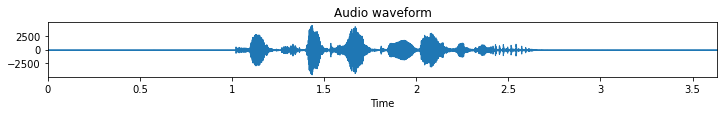

In [ ]:
_, sampling_rate = librosa.load(RAVDESS_FILE_EXAMPLE, sr = None)
visualize_waveform(audio_array=normalized_array, sampling_rate=sampling_rate, display_audio=True)

<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓ En observant la forme d'onde obtenue et en la comparant à celle du fichier d'origine, quel effet a eu ce pré-traitement sur le flux audio du fichier  ?</span></p>

Augmentation du gain => augmentation du volume perçu

<h4 style="text-align: left; color:#20a08d; font-size: 15px"><span>🗃️ <strong>3.1.3 Suppression des silences</strong></span></h4>

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code dans la fonction  <strong>remove_silence_from_audio</strong> permettant de supprimer les silences d'un contenu sonore, puis appelez cette fonction sur la matrice d'échantillon obtenue à l'étape précédente </span></p>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚  librosa.effects.trim : </span> <a href="https://librosa.org/doc/main/generated/librosa.effects.trim.html">https://librosa.org/doc/main/generated/librosa.effects.trim.html</a></p> 

In [ ]:
from librosa import effects

def remove_silence_from_audio(audio_array):
    
    '''
    Fonction permettant de supprimer les silences d'un fichier audio

            Parameters:
                    audio_array (Numpy array): Matrice de nombres représentant les échantillons du fichier audio sur lequel appliquer la suppression de silences

            Returns:
                    silenced_array (Numpy array) : Matrice de nombres représentant les échantillons du fichier audio après application du traitement
                    

    '''
    silenced_array, index = librosa.effects.trim(audio_array, top_db=30)
    #print(index)
    return silenced_array

In [ ]:
silenced_array = remove_silence_from_audio(normalized_array)

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code permettant d'écouter  et de visualiser la forme d'onde du flux audio résultant </span></p>

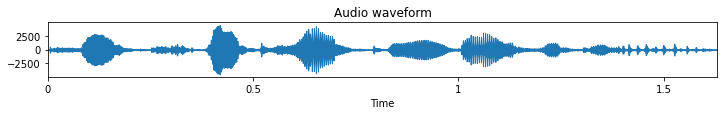

In [ ]:
visualize_waveform(audio_array=silenced_array, sampling_rate=sampling_rate, display_audio=True)

<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓ En observant la forme d'onde obtenue et en la comparant à celle obtenue à l'étape précédente, quel effet a eu ce pré-traitement sur le flux audio ?</span></p>

On a modifié la durée de l'audio en fixant le seuil top_db.

<h4 style="text-align: left; color:#20a08d; font-size: 15px"><span>🗃️ <strong>3.1.4 Egalisation des longueurs </strong></span></h4>

Ici, nous voulons uniformiser les données en entrée du modèle afin qu'elles aient toute la même longueur. Nous faisons arbitrairement le choix d'avoir des données en entrée du modèle correspondant à 2 secondes de fichier audio. Mais selon que le fichier audio appartienne au dataset TESS ou RAVDESS, 2 secondes ne correspondent pas au même nombre d'échantillons

In [ ]:
MAX_SECONDS = 2
SR_TESS = 22500
SR_RAVDESS = 48000

In [ ]:
MAX_SAMPLES_RAVDESS = MAX_SECONDS * SR_RAVDESS
MAX_SAMPLES_TESS = MAX_SECONDS * SR_TESS

In [ ]:
MAX_SAMPLES = np.max([MAX_SAMPLES_RAVDESS, MAX_SAMPLES_TESS])
MAX_SAMPLES

96000

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code dans la fonction  <strong>length_equalization_audio</strong> permettant de ramener chaque matrice d'échantillons audio à une longueur de MAX_SAMPLES (si les audios sont plus longues que 96000 échantillons, les couper pour les ramener à 96000, si les audio sont plus courtes que 96000 échantillons, rajouter des 0 pour les ramener à 96000 échantillons), puis appelez cette fonction sur la matrice d'échantillon obtenue à l'étape précédente </span></p>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚  numpy.pad : </span> <a href="https://numpy.org/doc/stable/reference/generated/numpy.pad.html">https://numpy.org/doc/stable/reference/generated/numpy.pad.html</a></p> 

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚  numpy.pad() function in Python : </span> <a href="https://www.geeksforgeeks.org/numpy-pad-function-in-python/">https://www.geeksforgeeks.org/numpy-pad-function-in-python/</a></p> 

In [ ]:
from numpy import pad

def length_equalization_audio(audio_array, max_length=MAX_SAMPLES):
    
    '''
    Fonction permettant de normaliser la longueur des échantillons d'un fichier audio

            Parameters:
                    audio_array (Numpy array): Matrice de nombres représentant les échantillons du fichier audio sur lequel appliquer l'égalisation des longueurs
                    max_length (int) : Nombre entier représentant la longueur en termes de nombre d'échantillons à avoir

            Returns:
                    padded_array (Numpy array) : Matrice de nombres représentant les échantillons du fichier audio de longueur max_length
                    

    '''
    if len(audio_array) < MAX_SAMPLES:
      equalized_array = pad(audio_array, pad_width=(0,MAX_SAMPLES-len(audio_array)), mode='constant', constant_values=(0,))
    else:
      equalized_array = audio_array[0:MAX_SAMPLES]
    assert len(equalized_array) == MAX_SAMPLES
    return equalized_array


In [ ]:
padded_array = length_equalization_audio(silenced_array, MAX_SAMPLES)
print('previous size: ', len(silenced_array), '\n', 'new size: ', len(padded_array))

previous size:  78336 
 new size:  96000


<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code permettant d'écouter  et de visualiser la forme d'onde du flux audio résultant </span></p>

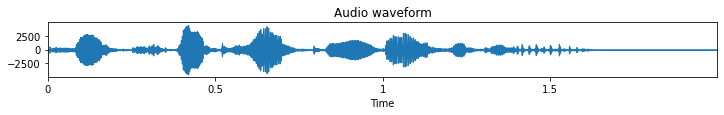

In [ ]:
visualize_waveform(audio_array=padded_array, sampling_rate=sampling_rate, display_audio=True)

<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓ En observant la forme d'onde obtenue et en la comparant à celle obtenue à l'étape précédente, quel effet a eu ce pré-traitement sur le flux audio ?</span></p>

Le zero padding a allongé la durée du signal sonore.

<h4 style="text-align: left; color:#20a08d; font-size: 15px"><span>🗃️ <strong>3.1.5 Suppression du bruit</strong></span></h4>

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code dans la fonction  <strong>noise_reduction_from_audio</strong> permettant de réduire le bruit dans chaque matrice d'échantillons audio, puis appelez cette fonction sur la matrice d'échantillon obtenue à l'étape précédente </span></p>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚  noisereduce : </span> <a href="https://github.com/timsainb/noisereduce#simplest-usage">https://github.com/timsainb/noisereduce#simplest-usage</a></p> 

In [ ]:
import noisereduce as nr

def noise_reduction_from_audio(audio_array, sampling_rate):
    '''
    Fonction permettant de supprimer le bruit d'un fichier audio

            Parameters:
                    audio_array (Numpy array): Matrice de nombres représentant les échantillons du fichier audio sur lequel appliquer la réduction de bruit
                    sampling_rate (int) : Nombre entier représentant la fréquence d'échantillonnage du fichier audio

            Returns:
                    noise_reduced_array (Numpy array) : Matrice de nombres représentant les échantillons du fichier audio après réduction du bruit

    '''
    noise_reduced_array = nr.reduce_noise(y=audio_array, sr=sampling_rate)
    return noise_reduced_array

In [ ]:
noise_reduced_array = noise_reduction_from_audio(padded_array, sampling_rate)

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code permettant d'écouter  et de visualiser la forme d'onde du flux audio résultant </span></p>

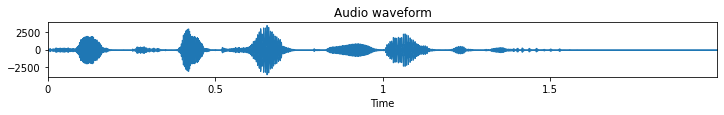

In [ ]:
visualize_waveform(audio_array=noise_reduced_array, sampling_rate=sampling_rate, display_audio=True)

<h3 style="text-align: left; color:#20a08d; font-size: 20px"><span>🗃️ <strong>3.2 Pré-traitement unifié </strong></span></h3>

Nous allons maintenant créer une fonction de pré-traitement globale, qui rassemble l'ensemble des pré-traitements précedemment développés.

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code dans la fonction  <strong>preprocess_audio</strong> permettant d'appliquer toutes les opérations de pré-traitement précédemment développées sur un fichier audio, puis appelez cette fonction sur le fichier audio exemple <strong>RAVDESS_FILE_EXAMPLE</strong></span></p>

In [ ]:
def preprocess_audio(audio_filename : str, sampling_rate : int):

    '''
    Fonction permettant d'appliquer toutes les opérations de pré-traitement sur un fichier audio

            Parameters:
                    audio_filename (str): Chaine de caractère correspondant au chemin d'accès au fichier audio
                    sampling_rate (int) : Nombre entier représentant la fréquence d'échantillonnage du fichier audio

            Returns:
                    noise_reduced_array (Numpy array) : Matrice de nombres représentant les échantillons du fichier audio après application de l'ensemble des pré-traitement
    '''
    ex_audio = AudioSegment.from_file(file = audio_filename,
                                      format = "wav")

    normalized_array = normalize_audio(ex_audio)
    silenced_array = remove_silence_from_audio(normalized_array)

    padded_array = length_equalization_audio(silenced_array, MAX_SAMPLES)
    noise_reduced_array = noise_reduction_from_audio(padded_array, sampling_rate)
    return noise_reduced_array

In [ ]:
preprocessed_array = preprocess_audio(RAVDESS_FILE_EXAMPLE, sampling_rate)

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code permettant d'écouter  et de visualiser la forme d'onde du flux audio résultant de l'ensemble des pré-traitements</span></p>

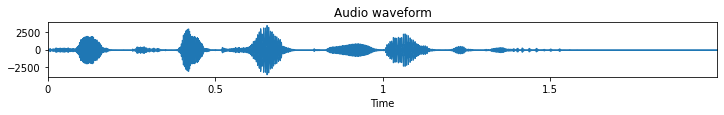

In [ ]:
visualize_waveform(audio_array=preprocessed_array, sampling_rate=sampling_rate, display_audio=True)

<h2 style="text-align: left; color:#20a08d; font-size: 25px"><span>
⛏️ <strong>4. Extraction des caractéristiques</strong></span></h2>

La spécifité des données audio est qu'elles nécessitent souvent des descripteurs de niveau intermédiaires pour être utilisées dans les modèles de machine learning. Ces descripteurs s'appellent aussi des caractéristiques. Nous allons ici extraire ces caractéristiques des fichiers audio que nous avons pré-traités

<h3 style="text-align: left; color:#20a08d; font-size: 20px"><span>⛏️ <strong>4.1 Extraction des caractéristiques unitaire </strong></span></h3>

Dans cette partie, nous développons pas à pas chacune des extractions de caractéristiques. Chaque extraction de caractéristique sera codée dans une fonction et testé sur la matrice numpy "preprocessed_array" obtenu en sortie de la fonction "preprocessed_audio".

Les caractéristiques à extraire via librosa sont les suivantes:

- Energy - Root Mean Square (RMS)
- Zero Crossed Rate (ZCR)
- Mel-Frequency Cepstral Coefficients (MFCCs)


Une des spécificités de l'audio est qu'aucune structuelle modulaire naturelle n'existe au sein d'un flux audio. 

Par exemple, au sein d'un flux vidéo, il existe une structure modulaire naturelle qui est l'image. Une vidéo de plusieurs heures peut ainsi être décomposée en plusieurs images. Ainsi à l'entrée des modèles de machine learning, il est possible d'utiliser une image ou un lot d'images.

Mais qu'en est-il de l'audio ? Dans le cas de l'audio, il revient au datascientist de séquencer un flux audio en plusieurs séquences en utilisant des techniques de **fenêtrage (windowing)**. 

![](https://drive.google.com/uc?export=view&id=1DtyatNBHGA08KxrOAG8zOtP8luN0V5LX)

C'est à partir de ces séquences fenêtrées que seront extraites les caractéristiques évoquées ci-dessus.

Fenêtrer revient donc à déplacer une fenêtre glissante d'une certaine largeur avec un pas de déplacement donné. La largeur de la fenêtre s'appelle **window_length** et le pas de déplacement s'appelle le **hop**.

![](https://drive.google.com/uc?export=view&id=1Z-ltJHFY56UKY7kzKB2jQY_XA177M5KD)

https://stackoverflow.com/questions/68214065/is-my-output-of-librosa-mfcc-correct-i-think-i-get-the-wrong-number-of-frames-w

In [ ]:
FRAME_LENGTH = 2048
HOP_LENGTH = 512

<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓ Avec une taille de fenêtre de <strong>FRAME_LENGTH</strong> et un pas de déplacement de <strong>HOP_LENGTH</strong>, en combien de fenêtres seront découpées les fichiers ayant 96000 échantillons ?</span></p>

NB_WINDOWS = ceil((96000-FRAME_LENGTH)/HOP_LENGTH)

On trouve NB_WINDOWS=184

<h4 style="text-align: left; color:#20a08d; font-size: 15px"><span>⛏️ <strong>4.1.1 Extraction de l'Energy Root Mean Square (RMS)</strong></span></h4>

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code dans la fonction  <strong>get_energy_rms</strong> permettant d'extraire l'energy RMS d'une matrice d'échantillons, puis appelez cette fonction sur la matrice d'échantillons audio pré-traités <strong>preprocessed_array</strong>. Attention à l'utilisation de l'argument <strong>"center"</strong></span></p>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚  librosa.feature.rms : </span> <a href="https://librosa.org/doc/main/generated/librosa.feature.rms.html">https://librosa.org/doc/main/generated/librosa.feature.rms.html</a></p> 

In [ ]:
from librosa.feature import rms

def get_energy_rms(audio_array : np.ndarray, frame_length, hop_length):
  '''
    Fonction permettant d'extraire d'une matrice d'échantillons audio l'energy RMS d'un flux audio

            Parameters:
                    audio_array (Numpy array): Matrice de nombres représentant les échantillons audio du fichier audio
                    frame_length (int): Valeur entière représentant la taille de fenêtre pour le fenêtrage
                    hop_length(int) : Valeur entière représentant la taille du pas de déplacement pour le fenêtrage


            Returns:
                    feature_rms (Numpy array): Matrice de nombres représentant l'energy rms
  '''
  # NOTE: Center must be set to False, otherwise it will generate a mirror version of input signal in the last frame,
  # to pad the signal (applying mirror elements) until the last window is complete. If enable, it will introduce new 
  # values (so new data...) which may fool the computed model... In this case, the number of generated RMS will be 
  # higher than expected (>184)
  #
  # Computation of a given characteristic on the last window:
  # Case center=False
  #               FRAME_LENGTH (last frame partially crossed)
  #  <...----------------X- - - - - - - ->
  #                   96000
  #   ...----------------|
  #            ...abcdef |
  #   ...----------------|
  # 
  #   ... RMS computation] (for example)
  # 
  # Case center=True
  #               FRAME_LENGTH (last frame mirrored)
  #  <...-------------------------------->
  #                   96000  (mirror)   96000+x
  #   ...---------------| - - - - - - - - |
  #            ...abcdef fedcba...        |
  #   ...---------------| - - - - - - - - |
  #
  #   .................... RMS computation] (for example)
  #
  # where x = 184*HOP_LENGTH + FRAME_LENGTH - 96000
  feature_rms = librosa.feature.rms(y=audio_array, S=None, frame_length=frame_length, hop_length=hop_length, center=False)
  return feature_rms

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code permettant d'afficher les dimensions de la matrice de caractéristiques résultante</span></p>

In [ ]:
feature_rms_array = get_energy_rms(preprocessed_array, FRAME_LENGTH, HOP_LENGTH)
print(feature_rms_array.shape)

(1, 184)


<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓ A quoi correspondent ces dimensions ?</span></p>

Le nombre de ligne correspond au fait qu'on travaille sur un signal 1D.
Le nombre de colonne est égale au nombre de fenêtre glissante, comme un RMS est calculé sur chaque fenêtre.

<h4 style="text-align: left; color:#20a08d; font-size: 15px"><span>⛏️ <strong>4.1.2 Extraction du Zero Crossing Rate (ZCR)</strong></span></h4>

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code dans la fonction  <strong>get_zcr</strong> permettant d'extraire le zero crossing rate d'une matrice d'échantillons audio, puis appelez cette fonction sur la matrice d'échantillons audio pré-traités<strong>preprocessed_array</strong></span></p>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚  librosa.feature.zero_crossing_rate : </span> <a href="http://librosa.org/doc/main/generated/librosa.feature.zero_crossing_rate.html">http://librosa.org/doc/main/generated/librosa.feature.zero_crossing_rate.html</a></p> 

In [ ]:
from librosa.feature import zero_crossing_rate

def get_zcr(audio_array, frame_length, hop_length):
    
    '''
    Fonction permettant d'extraire d'une matrice d'échantillons audio le ZCR d'un flux audio

            Parameters:
                    audio_array (Numpy array): Matrice de nombres représentant les échantillons audio du fichier audio
                    frame_length (int): Valeur entière représentant la taille de fenêtre pour le fenêtrage
                    hop_length(int) : Valeur entière représentant la taille du pas de déplacement pour le fenêtrage


            Returns:
                    feature_zcr (Numpy array): Matrice de nombres représentant le ZCR
                    

    '''
    feature_zcr = librosa.feature.zero_crossing_rate(y=audio_array, frame_length=frame_length, hop_length=hop_length, center=False)
    return feature_zcr

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code permettant d'afficher les dimensions de la matrice de caractéristiques résultante</span></p>

In [ ]:
feature_zcr = get_zcr(preprocessed_array, FRAME_LENGTH, HOP_LENGTH)
print(feature_zcr.shape)

(1, 184)


<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓ A quoi correspondent ces dimensions ?</span></p>

Idem question précèdente

<h4 style="text-align: left; color:#20a08d; font-size: 15px"><span>⛏️ <strong>4.1.3 Extraction des coefficients MFCC</strong></span></h4>

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code dans la fonction  <strong>get_mfcc</strong> permettant d'extraire les coefficients MFCC d'une matrice d'échantillons audio, puis appelez cette fonction sur la matrice d'échantillons audio pré-traités<strong>preprocessed_array</strong>. Utilisez 13 coefficients MFCC par fenêtre</span></p>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚  librosa.feature.mfcc : </span> <a href="https://librosa.org/doc/main/generated/librosa.feature.mfcc.html">https://librosa.org/doc/main/generated/librosa.feature.mfcc.html</a></p> 

In [ ]:
from librosa.feature import mfcc

def get_mfcc(audio_array, hop_length, sampling_rate):
    
    '''
    Fonction permettant d'extraire d'une matrice d'échantillons audio les coefficients MFCC d'un flux audio

            Parameters:
                    audio_array (Numpy array): Matrice de nombres représentant les échantillons audio du fichier audio
                    sampling_rate (int) : Nombre entier représentant la fréquence d'échantillonnage du fichier audio
                    hop_length (int) : Valeur entière représentant la taille du pas de déplacement pour le fenêtrage


            Returns:
                    feature_mfcc (Numpy array): Matrice de nombres représentant les coefficients MFCC
                    

    '''
    feature_mfcc = librosa.feature.mfcc(y=audio_array, sr=sampling_rate, hop_length=hop_length, n_mfcc=13, center=False)
    return feature_mfcc

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code permettant d'afficher les dimensions de la matrice de caractéristiques résultante</span></p>

In [ ]:
feature_mfcc = get_mfcc(preprocessed_array, HOP_LENGTH, sampling_rate)
print(feature_mfcc.shape)

(13, 184)


<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓ A quoi correspondent ces dimensions ?</span></p>

13 correspond au nombre de bande de fréquence: un MFCC sera calculé pour chaque bande. Ce nombre semble être optimale pour caractériser (en moyenne) une voix humaine.
184 correspond au nombre de fenêtres.

Utilisez le code ci-dessous pour afficher les coefficients MFCC

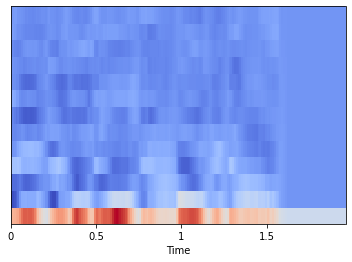

In [ ]:
librosa.display.specshow(feature_mfcc, sr=SR_RAVDESS, x_axis='time')

<h3 style="text-align: left; color:#20a08d; font-size: 20px"><span>⛏️ <strong>4.2 Extraction des caractéristiques unifiée </strong></span></h3>

Ici, nous rassemblons l'ensemble des traitements d'extractions de caractéristiques en une seule fonction, puis nous concaténons l'ensemble des caractéristiques RMS, ZCR, MFCC en une seule matrice.

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code dans la fonction  <strong>extract_features_audio</strong> permettant d'extraire d'une matrice d'échantillons audio l'ensemble des caractéristiques et des concaténer en une seule, puis appelez cette fonction sur la matrice d'échantillons audio pré-traités <strong>preprocessed_array</strong>.</span></p>

In [ ]:
def extract_features_audio(audio_array, sampling_rate, frame_length, hop_length):
    '''
    Fonction permettant d'extraire d'une matrice d'échantillons audio l'ensemble des caractéristiques et des concaténer en une seule

            Parameters:
                    audio_array (Numpy array): Matrice de nombres représentant les échantillons audio du fichier audio
                    sampling_rate (int) : Nombre entier représentant la fréquence d'échantillonnage du fichier audio
                    frame_length (int): Valeur entière représentant la taille de fenêtre pour le fenêtrage
                    hop_length (int) : Valeur entière représentant la taille du pas de déplacement pour le fenêtrage


            Returns:
                    features_all (Numpy array): Matrice de nombres représentant l'ensemble des caractéristiques concaténées
    '''
    # 1 x 184
    feature_rms_array = get_energy_rms(audio_array, frame_length, hop_length)
    # 1 x 184
    feature_zcr = get_zcr(audio_array, frame_length, hop_length)
    # 13 x 184
    feature_mfcc = get_mfcc(audio_array, hop_length, sampling_rate)
    # 15 x 184
    concatenated_array = np.concatenate((feature_rms_array, feature_zcr,feature_mfcc), axis=0)
    return concatenated_array

In [ ]:
features = extract_features_audio(preprocessed_array, sampling_rate, FRAME_LENGTH, HOP_LENGTH)
print(features.shape)

(15, 184)


<h2 style="text-align: left; color:#20a08d; font-size: 25px"><span>
🗄️ <strong>5. Application de la chaine complète de traitement des données: pré-traitement + extraction de caractéristiques</strong></span></h2>

Ici, nous rassemblons en une seule fonction l'ensemble des traitements : pré-traitement et extraction des caractéristiques

<h3 style="text-align: left; color:#20a08d; font-size: 20px"><span>🗄️ <strong>5.1 Traitement unitaire </strong></span></h3>

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code dans la fonction  <strong>process_data</strong> permettant de réaliser sur un fichier audio l'ensemble des traitéments de préparation des données (pré-traitement + extraction de caractéristiques), puis appelez cette fonction sur le fichier exemple <strong>RAVDESS_FILE_EXAMPLE</strong>.</span></p>

In [ ]:
def process_data(audio_filename, hop_length, frame_length, sampling_rate):
    
    '''
    Fonction permettant de réaliser sur un fichier audio l'ensemble des traitéments de préparation des données : pré-traitement + extraction de caractéristiques

            Parameters:
                    audio_filename (str): Chaine de caractère correspondant au chemin d'accès au fichier audio
                    sampling_rate (int) : Nombre entier représentant la fréquence d'échantillonnage du fichier audio
                    frame_length (int): Valeur entière représentant la taille de fenêtre pour le fenêtrage
                    hop_length (int) : Valeur entière représentant la taille du pas de déplacement pour le fenêtrage


            Returns:
                    preprocessed_array (Numpy array): Matrice de nombres représentant les échantillons audio après pré-traitement (normalisation, ...)
                    features (Numpy array): Matrice de nombres représentant l'ensemble des caractéristiques concaténées


    '''
    preprocessed_array = preprocess_audio(audio_filename, sampling_rate)
    features = extract_features_audio(preprocessed_array, sampling_rate, frame_length, hop_length)
    return preprocessed_array, features

In [ ]:
preprocessed_array, features = process_data(RAVDESS_FILE_EXAMPLE, HOP_LENGTH, FRAME_LENGTH, sampling_rate)

<h3 style="text-align: left; color:#20a08d; font-size: 20px"><span>🗄️ <strong>5.2 Détermination de la classe d'appartenance </strong></span></h3>

Le but ici est de développer une fonction permettante d'extraire la classe d'appartenance c'est-à-dire l'émotion exprimée dans un fichier audio à partir des données indiquées dans le nom de fichier.

Par convention :
- La classe **"neutre"** sera encodée par le nombre entier **0**
- La classe **"joie"** sera encodée par le nombre entier **1**
- La classe **"tristesse"** sera encodée par le nombre entier **2**
- La classe **"colere"** sera encodée par le nombre entier **3**

In [ ]:
EMOTION_DICT = {0:"neutre", 1:"joie", 2:"tristesse", 3:"colere"}

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code dans la fonction  <strong>get_ravdess_label</strong> permettant de déterminer la classe d'émotion exprimée dans un fichier audio RAVDESS à partir de son nom, puis appelez cette fonction sur les fichiers exemple <strong>RAVDESS_FILE_EXAMPLE_1</strong>, <strong>RAVDESS_FILE_EXAMPLE_2</strong>, <strong>RAVDESS_FILE_EXAMPLE_3</strong>, <strong>RAVDESS_FILE_EXAMPLE_4</strong>.</span></p>

In [ ]:
def get_ravdess_label(audio_filename):
    '''
    Fonction permettant de déterminer la classe d'émotion exprimée dans un fichier audio RAVDESS à partir de son nom

            Parameters:
                    audio_filename (str): Chaine de caractère correspondant au chemin d'accès au fichier audio

            Returns:
                    - (int): Nombre entier représentant la classe de l'émotion
    '''
    emotion_code_ravdess = int(audio_filename.split('-')[2])
    emotion_code_common = -1
    # Recall: 
    # => Our EMOTION_DICT = {0:"neutre", 1:"joie", 2:"tristesse", 3:"colere"}
    # => Ravdess: Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
    # NOTE: could be more readable with Python's enums.
    # neutral
    if emotion_code_ravdess == 1:
      emotion_code_common = 0
    # joy
    elif emotion_code_ravdess == 3:
      emotion_code_common = 1
    # sadness
    elif emotion_code_ravdess == 4:
      emotion_code_common = 2
    # angryness
    elif emotion_code_ravdess == 5:
      emotion_code_common = 3
    # assert if not in the allowed range
    assert emotion_code_common >= 0 and emotion_code_common <= 3
    # or (more prone to changes) try directly to access to an element and see if it triggers an exception...
    # try:
    #   EMOTION_DICT[emotion_code_common]
    # except KeyError:
    #   assert true, f"invalid emotion code: {emotion_code_common}"
    return emotion_code_common

In [ ]:
RAVDESS_FILE_EXAMPLE_1 = "./dataset/ravdess/03-01-04-01-02-02-22.wav"
RAVDESS_FILE_EXAMPLE_2 = "./dataset/ravdess/03-01-05-01-02-01-19.wav"
RAVDESS_FILE_EXAMPLE_3 = "./dataset/ravdess/03-01-03-01-02-02-11.wav"
RAVDESS_FILE_EXAMPLE_4 = "./dataset/ravdess/03-01-01-01-01-02-20.wav"
print(RAVDESS_FILE_EXAMPLE_1, EMOTION_DICT[get_ravdess_label(RAVDESS_FILE_EXAMPLE_1)])
print(RAVDESS_FILE_EXAMPLE_2, EMOTION_DICT[get_ravdess_label(RAVDESS_FILE_EXAMPLE_2)])
print(RAVDESS_FILE_EXAMPLE_3, EMOTION_DICT[get_ravdess_label(RAVDESS_FILE_EXAMPLE_3)])
print(RAVDESS_FILE_EXAMPLE_4, EMOTION_DICT[get_ravdess_label(RAVDESS_FILE_EXAMPLE_4)])

./dataset/ravdess/03-01-04-01-02-02-22.wav tristesse
./dataset/ravdess/03-01-05-01-02-01-19.wav colere
./dataset/ravdess/03-01-03-01-02-02-11.wav joie
./dataset/ravdess/03-01-01-01-01-02-20.wav neutre


<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code dans la fonction  <strong>get_tess_label</strong> permettant de déterminer la classe d'émotion exprimée dans un fichier audio TESS à partir de son nom, puis appelez cette fonction sur les fichiers exemple <strong>TESS_FILE_EXAMPLE_1</strong>, <strong>TESS_FILE_EXAMPLE_2</strong>, <strong>TESS_FILE_EXAMPLE_3</strong>, <strong>TESS_FILE_EXAMPLE_4</strong>.</span></p>

In [ ]:
def get_tess_label(audio_filename):
    '''
    Fonction permettant de déterminer la classe d'émotion exprimée dans un fichier audio TESS à partir de son nom

            Parameters:
                    audio_filename (str): Chaine de caractère correspondant au chemin d'accès au fichier audio

            Returns:
                    - (int): Nombre entier représentant la classe de l'émotion
    '''
    # Recall:
    # => Our EMOTION_DICT = {0:"neutre", 1:"joie", 2:"tristesse", 3:"colere"}
    # => tess: neutral, happy, sad, angry

    # split twice (first on '_' and then remove the '.wav')
    emotion_str_tess = audio_filename.split('_')[2].split('.')[0]
    emotion_code_common = -1

    if emotion_str_tess == "neutral":
      emotion_code_common = 0
    elif emotion_str_tess == "happy":
      emotion_code_common = 1
    elif emotion_str_tess == "sad":
      emotion_code_common = 2
    elif emotion_str_tess == "angry":
      emotion_code_common = 3
    
    # assert if not in the allowed range
    assert emotion_code_common >= 0 and emotion_code_common <= 3
    return emotion_code_common

In [ ]:
TESS_FILE_EXAMPLE_1 = "./dataset/tess/OAF_lose_sad.wav"
TESS_FILE_EXAMPLE_2 = "./dataset/tess/YAF_mop_happy.wav"
TESS_FILE_EXAMPLE_3 = "./dataset/tess/OAF_turn_neutral.wav"
TESS_FILE_EXAMPLE_4 = "./dataset/tess/YAF_met_angry.wav"
print(TESS_FILE_EXAMPLE_1, EMOTION_DICT[get_tess_label(TESS_FILE_EXAMPLE_1)])
print(TESS_FILE_EXAMPLE_2, EMOTION_DICT[get_tess_label(TESS_FILE_EXAMPLE_2)])
print(TESS_FILE_EXAMPLE_3, EMOTION_DICT[get_tess_label(TESS_FILE_EXAMPLE_3)])
print(TESS_FILE_EXAMPLE_4, EMOTION_DICT[get_tess_label(TESS_FILE_EXAMPLE_4)])

./dataset/tess/OAF_lose_sad.wav tristesse
./dataset/tess/YAF_mop_happy.wav joie
./dataset/tess/OAF_turn_neutral.wav neutre
./dataset/tess/YAF_met_angry.wav colere


<h3 style="text-align: left; color:#20a08d; font-size: 20px"><span>🗄️ <strong>5.3 Traitement de l'ensemble des fichiers audio </strong></span></h3>

Nous disposons désormais de tous les éléments permettant d'obtenir les données d'entrainement (caractéristiques) et les labels associés

Puisque nous utilisons de l'apprentissage supervisé, il nous faut créer un tableau de données (caractéristisques) et un tableau de labels

![](https://drive.google.com/uc?export=view&id=1YlUfk9mKgcCWedr4bhPW4bXOp1_qYWud)

In [ ]:
DATASET_FOLDER = "./dataset"
DATASET_SUBFOLDER_RAVDESS = "ravdess"
DATASET_SUBFOLDER_TESS = "tess"
features_list = list()
labels_list = list()

<p style="text-align: left; font-size: 16px; color:#131fcf"><span>🖥️  Ecrivez le code permettant de parcourir les fichiers audio RAVDESS et TESS, d'en déterminer la fréquence d'échantillonnage, de calculer la matrice de caractéristiques du fichier audio, d'extraire la classe d'appartenance du fichier audio, puis insérer la matrice de caractéristiques et la classe d'appartenance respectivement dans les listes <strong>features_list</strong> et <strong>labels_list</strong>. Convertissez enfin les listes <strong>features_list</strong> et <strong>labels_list</strong> en matrice numpy array <strong>features_array</strong> et <strong>labels_array</strong></span></p>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚  
Iterate over files in a directory in Python
 : </span> <a href="https://www.techiedelight.com/iterate-over-files-directory-python/">https://www.techiedelight.com/iterate-over-files-directory-python/</a></p> 

In [ ]:
from librosa.core import get_samplerate
import os
from pydub import exceptions

# delete previously inserted content...
features_list = list()
labels_list = list()

for subfolder in [DATASET_SUBFOLDER_RAVDESS, DATASET_SUBFOLDER_TESS]:
  subfolder_path = os.path.join(DATASET_FOLDER, subfolder)
  for filename in os.listdir(subfolder_path):
    f = os.path.join(subfolder_path, filename)
    if os.path.isfile(f):
      sampling_rate = librosa.get_samplerate(f)
      try:
        _, features = process_data(f, HOP_LENGTH, FRAME_LENGTH, sampling_rate)
      # apparently, one file is corrupted in the DB...
      except exceptions.CouldntDecodeError:
        print(f"file {f} corrupted! Bypassing the file...")
        continue
      label = -1
      if subfolder == DATASET_SUBFOLDER_TESS:
        label = get_tess_label(f)
      elif subfolder == DATASET_SUBFOLDER_RAVDESS:
        label = get_ravdess_label(f)
      assert label >= 0 and label <= 3
      features_list.append(features)
      labels_list.append(label)
  
features_array = np.array(features_list)
labels_array = np.array(labels_list)

file ./dataset/tess/YAF_germ_angry.wav corrupted! Bypassing the file...


In [ ]:
print(features_array.shape)
print(labels_array.shape)

(2271, 15, 184)
(2271,)


<h2 style="text-align: left; color:#20a08d; font-size: 25px"><span>
📼 <strong>6. Sauvegarde des données d'entrainement et des labels</strong></span></h2>

Nous allons ici sauvegarder sur notre disque les données d'entrainement et les labels correspondant aux matrices que nous avons générées.

Pour ce faire, nous utiliserons la librairie pickle qui permet d'enregistrer des données en gardant leur structure d'origine.

In [ ]:
import pickle

with open('./features.array', 'wb') as features:
    pickle.dump(features_array, features)

In [ ]:
import pickle

with open('./labels.array', 'wb') as labels:
    print(labels_array)
    pickle.dump(labels_array, labels)

[2 0 1 ... 3 3 2]


<h2 style="text-align: left; color:#20a08d; font-size: 25px"><span>
📼 <strong>7. Sauvegarde des fonctions de pré-traitement en script Python</strong></span></h2>

Copier ci-dessous le contenu des fonctions ci-dessous:
- normalize_audio
- remove_silence_from_audio
- length_equalization_audio
- noise_reduction_from_audio
- preprocess_audio
- get_energy_rms()
- get_zcr()
- get_mfcc()
- extract_features_audio()
- process_data()

In [ ]:
%%writefile ../3.RealtimeEvaluation/preprocessing.py
MAX_SAMPLES = 96000

import os
import numpy as np
import random

from pydub import AudioSegment, effects
import librosa
import soundfile as sf
from scipy.io import wavfile
import noisereduce as nr

import matplotlib.pyplot as plt
from librosa import display



Writing ../3.RealtimeEvaluation/preprocessing.py


In [ ]:
 %%shell
jupyter nbconvert --to html DataPreprocessing.ipynb

[NbConvertApp] Converting notebook DataPreprocessing.ipynb to html
[NbConvertApp] Writing 832752 bytes to DataPreprocessing.html
